In [1]:
# conda create -n fastai python=3.7
# conda activate fastai
# conda install -c conda-forge jupyterlab
# conda install pytorch torchvision torchaudio -c pytorch
# pip install fastai
# conda install -c anaconda ipykernel
# python -m ipykernel install --user --name=fastai

In [1]:
import fastai
print(fastai.__version__)
from fastai.vision.gan import *
from fastai.vision.all import *
from fastai.vision.data import *
from tqdm.notebook import tqdm

2.6.3


In [2]:
path =  "./../data/test/data0/lsun/bedroom" #"./../../../../Downloads/archive/data0/lsun/bedroom"  # TODO: zmiana elementu "test" w ścieżce na "sample" # Zmienione z .. na . na początku

In [3]:
# bs = 128
bs = 12
size = 64

In [4]:
path_lr = './../data/test/data0/lsun/small-96'  # TODO: zmiana elementu "test" w ścieżce na "sample"
path_hr = './../data/test/data0/lsun/bedroom'  # TODO: zmiana elementu "test" w ścieżce na "sample"

In [5]:
from PIL import Image, ImageDraw, ImageFont

In [6]:
def resize_to(img, targ_sz, use_min=False):
    w,h = img.size
    min_sz = (min if use_min else max)(w,h)
    ratio = targ_sz/min_sz
    return int(w*ratio),int(h*ratio)

In [7]:
class Crappifier():
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
    def __call__(self, fn):       
        dest = self.path_lr/fn.relative_to(self.path_hr)
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

In [8]:
def get_dls(bs:int, size:int):
    dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(seed=123),
                   item_tfms=Resize(size),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])
    dls = dblock.dataloaders(path_lr, bs=bs, path=path)
    dls.c = 3
    return dls

In [9]:
items = get_image_files(path_hr)

In [10]:
for item in tqdm(items):
    Crappifier(path_lr, path_hr).__call__(item) # robi nowe obrazki

  0%|          | 0/30999 [00:00<?, ?it/s]

In [11]:
import torch
torch.cuda.is_available()

True

In [15]:
dls_gen = get_dls(bs, 64) #128)

In [20]:
wd, y_range, loss_gen = 1e-6, (-3., 3.), MSELossFlat()

In [21]:
bbone = resnet18

In [22]:
def create_gen_learner():
    return unet_learner(dls_gen, bbone, loss_func=loss_gen, blur=True, norm_type=NormType.Weight, self_attention=True, y_range=y_range)

In [16]:
learn_gen = create_gen_learner()

In [17]:
learn_gen.fit_one_cycle(1, pct_start=0.8, wd=wd) 

epoch,train_loss,valid_loss,time


In [24]:
learn_gen.unfreeze()

In [25]:
learn_gen.fit_one_cycle(1, slice(1e-6,1e-3), wd=wd)

epoch,train_loss,valid_loss,time
0,0.000405,0.000776,02:07


In [27]:
learn_gen.save('gen-pre3') #2')

Path('../data/test/data0/lsun/bedroom/models/gen-pre3.pth')

In [23]:
# Save the generated images so they can be used them for critic model
name_gen = 'image_gen'
path_gen = Path(f'./../data/test/data0/lsun/{name_gen}')

In [29]:
path_gen.mkdir(exist_ok=True)

In [14]:
def save_preds(dl, learn):
    "Save away predictions"
    names = dl.dataset.items

    preds,_ = learn.get_preds(dl=dl)
    for i, pred in enumerate(preds):
        dec = dl.after_batch.decode((TensorImage(pred[None]),))[0][0]
        arr = dec.numpy().transpose(1,2,0).astype(np.uint8)
        Image.fromarray(arr).save(path_gen/names[i].name)

In [31]:
dl = dls_gen.train.new(shuffle=False, drop_last=False, 
                       after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [38]:
save_preds(dl, learn_gen)

In [93]:
# Train the critic

In [24]:
path_g = get_image_files( Path(path_gen))
path_i = get_image_files(Path(path_hr))
fnames = path_g + path_i

In [25]:
fnames[0]

Path('../data/test/data0/lsun/image_gen/340c82239b2d25d4d1cf745ff37632f9ae4ef73f.jpg')

In [26]:
def get_crit_dls(fnames, bs:int, size:int):
    "Generate two `Critic` DataLoaders"
    splits = RandomSplitter(0.1)(fnames)
    dsrc = Datasets(fnames, tfms=[[PILImage.create], [parent_label, Categorize]],
                 splits=splits)
    tfms = [ToTensor(), Resize(size)]
    gpu_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
    return dsrc.dataloaders(bs=bs, after_item=tfms, after_batch=gpu_tfms)

In [27]:
dls_crit = get_crit_dls(fnames, bs=bs, size=64) # 128)

In [29]:
loss_crit = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [30]:
def create_crit_learner(dls, metrics):
    return Learner(dls, gan_critic(), metrics=metrics, loss_func=loss_crit)

In [47]:
learn_crit = create_crit_learner(dls_crit, accuracy_thresh_expand)

In [48]:
learn_crit.fit_one_cycle(1, 1e-4, wd=wd) # 1e-3

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,-122768.148438,-122870.117188,0.034660,06:00


In [49]:
learn_crit.save('critic-pre3') # 2

Path('models/critic-pre3.pth')

In [50]:
# The GAN

In [31]:
ls_crit = get_crit_dls(fnames, bs=bs, size=64)#128)

In [32]:
learn_crit = create_crit_learner(ls_crit, metrics=None).load('critic-pre3') #2

In [33]:
learn_gen = create_gen_learner().load('gen-pre3') #2

In [34]:
class GANDiscriminativeLR(Callback):
    "`Callback` that handles multiplying the learning rate by `mult_lr` for the critic."
    def __init__(self, mult_lr=5.): self.mult_lr = mult_lr

    def begin_batch(self):
        "Multiply the current lr if necessary."
        if not self.learn.gan_trainer.gen_mode and self.training: 
            self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']*self.mult_lr)

    def after_batch(self):
        "Put the LR back to its value if necessary."
        if not self.learn.gan_trainer.gen_mode: self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']/self.mult_lr)

In [35]:
switcher = AdaptiveGANSwitcher(critic_thresh=.65)

In [36]:
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(Adam, mom=0.), cbs=GANDiscriminativeLR(mult_lr=5.))

In [37]:
lr = 1e-4

In [38]:
learn.fit(10, lr, wd=wd)

/home/agatamakarewicz/anaconda3/lib/python3.9/site-packages/fastai/callback/core.py:67: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/agatamakarewicz/anaconda3/lib/python3.9/site-packages/fastai/callback/core.py:67: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/agatamakarewicz/anaconda3/lib/python3.9/site-packages/fastai/callback/core.py:67: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,gen_loss,crit_loss,time
0,5996.464355,0.044996,0.044996,5952.878906,07:18
1,6074.047852,0.044996,0.044996,5440.343750,07:44
2,6042.964844,0.044996,0.044996,6571.562988,07:44
3,5914.358887,0.044996,0.044996,6959.235840,07:41
4,6021.091309,0.044996,0.044996,6034.638672,07:41
5,5831.079102,0.044996,0.044996,6816.565430,07:42
6,5815.948242,0.044996,0.044996,4874.709961,07:44
7,5871.582520,0.044996,0.044996,5601.537598,07:45
8,6134.320801,0.044996,0.044996,4892.370117,07:38
9,5852.951660,0.044996,0.044996,5848.696289,07:31


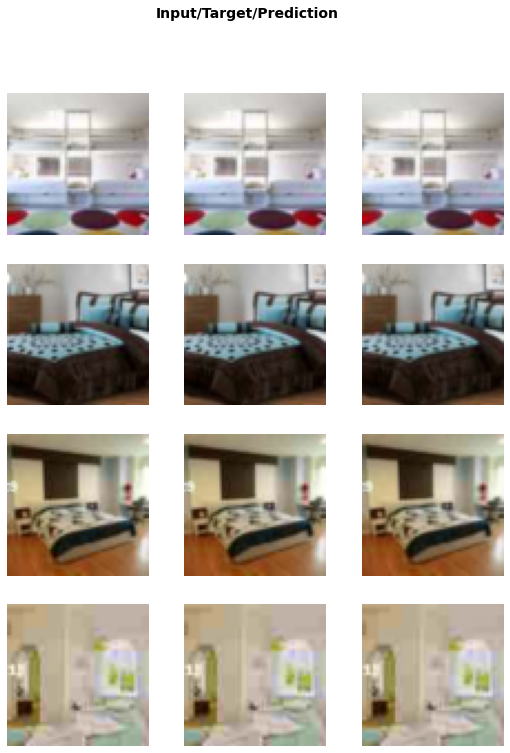

In [39]:
learn.show_results(max_n=4)

In [49]:
preds = learn.get_preds()

/home/agatamakarewicz/anaconda3/lib/python3.9/site-packages/fastai/callback/core.py:67: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/agatamakarewicz/anaconda3/lib/python3.9/site-packages/fastai/callback/core.py:67: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/agatamakarewicz/anaconda3/lib/python3.9/site-packages/fastai/callback/core.py:67: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


In [55]:
preds

(TensorBase([[[[-1.4220e-01, -1.1018e-01, -2.4927e-02,  ...,  6.9141e-01,
             7.0366e-01,  6.2999e-01],
           [-2.4033e-01, -1.7775e-01, -9.1373e-02,  ...,  7.1790e-01,
             7.3384e-01,  6.8642e-01],
           [-3.0777e-01, -2.5077e-01, -1.7345e-01,  ...,  7.2826e-01,
             7.0399e-01,  7.0466e-01],
           ...,
           [ 4.6409e-01,  4.7914e-01,  4.6523e-01,  ...,  7.1630e-01,
             6.8852e-01,  7.1393e-01],
           [ 5.6396e-01,  5.5529e-01,  4.7581e-01,  ...,  7.1368e-01,
             8.1376e-01,  8.5491e-01],
           [ 5.8438e-01,  5.6273e-01,  4.7105e-01,  ...,  7.3351e-01,
             8.3335e-01,  8.5262e-01]],
 
          [[-2.8656e-01, -2.4486e-01, -1.6572e-01,  ...,  8.2123e-01,
             8.0951e-01,  7.4839e-01],
           [-3.7533e-01, -3.1468e-01, -2.3696e-01,  ...,  8.5667e-01,
             8.6123e-01,  8.4841e-01],
           [-4.5645e-01, -4.1543e-01, -3.1977e-01,  ...,  8.6678e-01,
             8.5353e-01,  8.4314e-0

In [41]:
from tqdm import tqdm
img = []
for item in tqdm(dls_gen.valid_ds.items):
    im = PILImage.create(item)
    im = im.resize((64,64))
    im_tensor = image2tensor(im)
    img.append(im_tensor)

100%|██████████| 6199/6199 [00:03<00:00, 1981.51it/s]


In [42]:
import pytorch_fid_wrapper as pfw
real_m, real_s = pfw.get_stats(torch.stack(img).type(torch.FloatTensor))

In [56]:
pfw.fid(torch.tensor(preds[1]).type(torch.FloatTensor), real_m=real_m, real_s=real_s) # (1)

/tmp/ipykernel_26120/1453472562.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pfw.fid(torch.tensor(preds[1]).type(torch.FloatTensor), real_m=real_m, real_s=real_s) # (1)


8717.051500433321